# Lab 1

In this notebook the following networks are implemented:
* radial basis function
* self organising maps

**Imports**

In [72]:
%load_ext autoreload
%autoreload 2

import numpy as np
import math
from scipy import signal
import matplotlib.pyplot as plt
from lab2_utils import RBF, cl_competitive, SOM
from sklearn.neural_network import MLPRegressor
import os 
import pandas as pd
from numpy.linalg import norm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
data_set_path = '/Users/brenoaberle/Documents/KTH/Artificial_Neural_Networks_and_Deep_Architectures/Assignments/Lab2/data_lab2/'

## Part I: Radial Basis Function

### Batch mode training using least squares - supervised learning of network weights

Build an RBF network to solve a regression problem with batch learning. Functions to approximate are:
* sin(2x)
* square(2x) (square is a rect- angular curve serving as a "box" envelope for the sine wave, i.e. it is 1 for arguments where the sin>=0 and -1 otherwise)

 

#### Data set creation
Dataset in the interval [0,2π] 

In [74]:
# Training
x_train = np.arange(0, 2 * math.pi, 0.1)
y_sin_train = np.sin(2 * x_train)
y_square_train = signal.square(2 * x_train)

# Test
x_test = np.arange(0.05, 2 * math.pi, 0.1)
y_sin_test = np.sin(2 * x_test)
y_square_test = signal.square(2 * x_test)

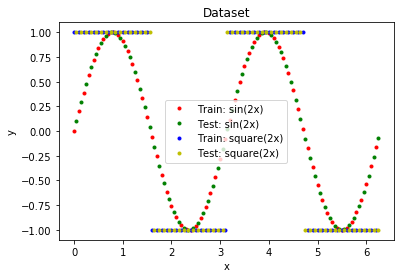

In [75]:
plt.plot(x_train, y_sin_train,'r.', label="Train: sin(2x)")
plt.plot(x_test, y_sin_test,'g.', label="Test: sin(2x)")
plt.plot(x_train, y_square_train, 'b.', label="Train: square(2x)")
plt.plot(x_test, y_square_test, 'y.', label="Test: square(2x)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Dataset")
plt.legend()

#### RBF, varrying number of units
Try to vary the number of units to obtain the absolute residual error below 0.1, 0.01 and 0.001 in the residual value Please discuss the results, how many units are needed for the aforementioned error thresholds?

For the Sinus Function (with sigma=1) we need : 
* at least 6 nodes for error < 0.1
* at least 11 nodes for error < 0.01
* at least 13 nodes for error < 0.001

For the Square Function (with sigma=0.09) we need : 
* at least 200 nodes for error < 0.1
* didn't get a smaller error than 0.1

-> Rectangular Function are hard for rbfs

In [76]:
mus = [0,0.2, 0.9, 1.4, 1.7, 2.2, 3, 3.5, 4.2, 4.5, 4.9, 5.5, 6.1 ]

rbf_sin = RBF(num_nodes=13, sigma=1, mus=mus)
rbf_sin.fit(x_train, y_sin_train)

rbf_square = RBF(num_nodes=13, sigma=1.5, mus=mus)
rbf_square.fit(x_train, y_square_train)

In [77]:
output_sin = rbf_sin.predict(x_test)
print('Error for Sin function is:  ', np.mean(abs(y_sin_test - output_sin)))
output_square = rbf_square.predict(x_test)
print('Error for Square function is:  ', np.mean(abs(y_square_test - output_square)))

Error for Sin function is:   9.849700659006246e-05
Error for Square function is:   0.26373436108290677


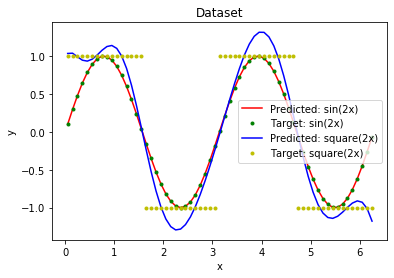

In [78]:
plt.plot(x_test, output_sin,'r', label="Predicted: sin(2x)")
plt.plot(x_test, y_sin_test,'g.', label="Target: sin(2x)")
plt.plot(x_test, output_square, 'b', label="Predicted: square(2x)")
plt.plot(x_test, y_square_test, 'y.', label="Target: square(2x)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Dataset")
plt.legend()

#### Function on Square output
How can you simply transform the output of your RBF network to reduce the residual error to 0 for the square(2x) problem? Still, how many units do you need? In what type of applications could this transform be particularly useful?

Transform by Threshold function: 
f(output) =1 if x>=0,else -1

For the Square Function we need : 
* 5 nodes and sigma of 1.4 for error < 0.1
* 10 nodes and a sigma of 0.9 to achieve an error of 0

-> transformation useful for rectangular functions


Error for transformed square function is:   0.0


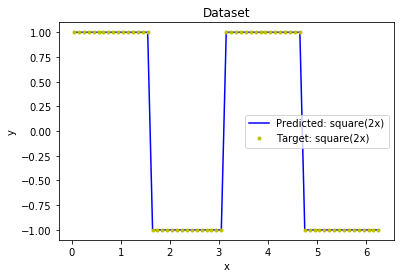

In [79]:
rbf_square = RBF(num_nodes=10, sigma=0.9)
rbf_square.fit(x_train, y_square_train)
output_square = rbf_square.predict(x_test)
new_output = list(map(lambda x: 1 if x>=0 else -1, output_square))
print('Error for transformed square function is:  ', np.mean(abs(y_square_test - new_output)))
plt.plot(x_test, new_output, 'b', label="Predicted: square(2x)")
plt.plot(x_test,  y_square_test, 'y.', label="Target: square(2x)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Dataset")
plt.legend()

### Regression with noise
new data creation with Gaussian noise

#### Data set creation
Dataset as in 3.1 but with zero-mean Gaussian noise with the variance of 0.1 added in the interval [0,2π] 

In [80]:
# Training
y_sin_train_noisy = y_sin_train + np.random.normal(0, 0.1, len(x_train))
y_square_train_noisy = y_square_train + np.random.normal(0, 0.1, len(x_train))

# Test
y_sin_test_noisy = y_sin_test + np.random.normal(0, 0.1, len(x_train))
y_square_test_noisy = y_square_test + np.random.normal(0, 0.1, len(x_train))

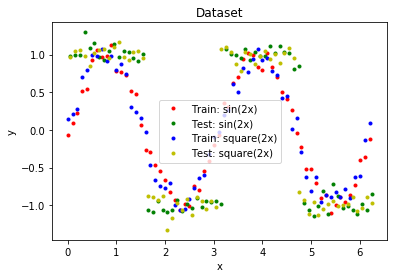

In [81]:
plt.plot(x_train, y_sin_train_noisy, "r.", label="Train: sin(2x)")
plt.plot(x_test, y_square_train_noisy, "g.", label="Test: sin(2x)")
plt.plot(x_train, y_sin_test_noisy, "b.", label="Train: square(2x)")
plt.plot(x_test, y_square_test_noisy, "y.", label="Test: square(2x)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Dataset")
plt.legend()

#### Width and Units Effect

*Compare the effect of the number of RBF units and their width for the two learning approaches. Which error estimate should you choose as the criterion for these comparative analyses?*

---

Observations for online: 
* number of nodes must be more than with batch
* a lot of iteration needed
* width works as for batch learning

Observations for batch:
* works as without noise -> the width should be around 1 and the more number of nodes the better the algorithm performes

Error used in this case again the mean absolute error

*What are the main effects of changing the width of RBFs?*

---

* Error varies
* smaller width needs more num_nodes
* width decide over the best accuracy

In [82]:
rbf_sin_batch = RBF(num_nodes=13, sigma=1)
rbf_sin_batch.fit(x_train, y_sin_train_noisy)
output_sin_batch = rbf_sin_batch.predict(x_test)
print('The error for Sin function in batch learning with noisy data is: ', np.mean(abs(y_sin_test_noisy - output_sin_batch)))

The error for Sin function in batch learning with noisy data is:  0.09528466375263592


In [83]:
rbf_sin_online = RBF(num_nodes=40, sigma=1)
rbf_sin_online.fit_delta(x_train, y_sin_train_noisy, num_epochs=2000)
output_sin_online = rbf_sin_online.predict(x_test)
print('The error for Sin function in online learning with noisy data is: ', np.mean(abs(y_sin_test_noisy - output_sin_online)))

The error for Sin function in online learning with noisy data is:  0.11882170429498351


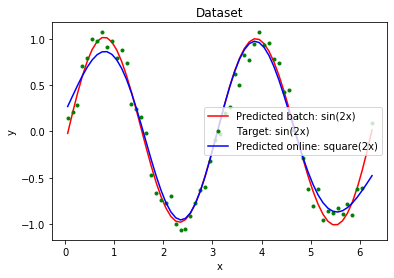

In [84]:
plt.plot(x_test, output_sin_batch,'r', label="Predicted batch: sin(2x)")
plt.plot(x_test, y_sin_test_noisy ,'g.', label="Target: sin(2x)")
plt.plot(x_test, output_sin_online, 'b', label="Predicted online: square(2x)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Dataset")
plt.legend()

#### Learning Rate

*What can you say about the rate of convergence and its dependence on the learning rate, eta, for the two learning schemes?*

For batch: 
* Coverges directly no learning rate needed

For online: 
* takes at least 20 epochs to converge
* learning rate optimal with 0.1 / 0.01

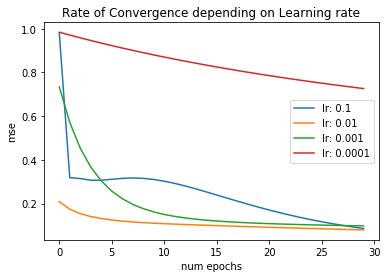

In [88]:
learning_rates = [0.1,0.01, 0.001, 0.0001]
num_epochs = 30
for lr in learning_rates:
    rbf_sin_online = RBF(num_nodes=30, sigma=0.9)
    err_scores = rbf_sin_online.fit_delta(
        x_train, y_sin_train_noisy, learning_rate=lr, num_epochs=num_epochs, error_scores=True
    )
    plt.plot(np.arange(0,num_epochs,1), err_scores, label="lr: {}".format(lr))
plt.xlabel("num epochs")
plt.ylabel("mse")
plt.title("Rate of Convergence depending on Learning rate")
plt.legend()

#### Positioning of RBF Nodes

How important is the positioning of the RBF nodes in the input space? What strategy did you choose? Is it better than random positioning of the RBF nodes? Please support your conclusions with quantitative evidence (e.g., error comparison).

---

Strategies: 
* at all turnpoints/max/minima
* only maxima/minima
* random

-> Random positioning works slightly better
-> The more nodes the better is random

Also, for the same network models estimate their test performance on the original clean data used in section 3.1 (a corresponding test subset but without noise) and compare your Findings.

---
-> Around the same error as with noise

In [86]:
# at all turnpoints/max/minima
rbf_sin_all = RBF(num_nodes=8, sigma=1, mus=[0., 0.8, 1.6, 2.4, 3.1, 3.9, 4.7, 5.5])
rbf_sin_all.fit_delta(x_train, y_sin_train_noisy, num_epochs=30, learning_rate=0.01)
output_sin_all = rbf_sin_online.predict(x_test)
print('at all turnpoints/max/minima (8 nodes):')
print('The error for Sin function in online learning with noisy data is: ', np.mean(abs(y_sin_test_noisy - output_sin_all)))
print('The error for Sin function in online learning without noisy data is: ', np.mean(abs(y_sin_test - output_sin_all)))

# max/minima
rbf_sin_max_min = RBF(num_nodes=4, sigma=1, mus=[0.8, 2.4, 3.9,  5.5])
rbf_sin_max_min.fit_delta(x_train, y_sin_train_noisy, num_epochs=30, learning_rate=0.01)
output_sin_max_min = rbf_sin_max_min.predict(x_test)
print('max/minima (4 nodes):')
print('The error for Sin function in online learning with noisy data is: ', np.mean(abs(y_sin_test_noisy - output_sin_max_min)))
print('The error for Sin function in online learning without noisy data is: ', np.mean(abs(y_sin_test - output_sin_max_min)))

# random
rbf_sin_ramdom = RBF(num_nodes=8, sigma=1)
rbf_sin_ramdom.fit_delta(x_train, y_sin_train_noisy, num_epochs=30, learning_rate=0.01)
output_sin_ramdom = rbf_sin_ramdom.predict(x_test)
print('random (8 nodes):')
print('The error for Sin function in online learning with noisy data is: ', np.mean(abs(y_sin_test_noisy - output_sin_ramdom)))
print('The error for Sin function in online learning without noisy data is: ', np.mean(abs(y_sin_test - output_sin_ramdom)))

# random
rbf_sin_ramdom = RBF(num_nodes=4, sigma=1)
rbf_sin_ramdom.fit_delta(x_train, y_sin_train_noisy, num_epochs=30, learning_rate=0.01)
output_sin_ramdom = rbf_sin_ramdom.predict(x_test)
print('random (4 nodes):')
print('The error for Sin function in online learning with noisy data is: ', np.mean(abs(y_sin_test_noisy - output_sin_ramdom)))
print('The error for Sin function in online learning without noisy data is: ', np.mean(abs(y_sin_test - output_sin_ramdom)))

at all turnpoints/max/minima (8 nodes):
The error for Sin function in online learning with noisy data is:  0.6203026557120319
The error for Sin function in online learning without noisy data is:  0.6122295465309904
max/minima (4 nodes):
The error for Sin function in online learning with noisy data is:  0.34006223715128253
The error for Sin function in online learning without noisy data is:  0.33445789591374253
random (8 nodes):
The error for Sin function in online learning with noisy data is:  0.49100199592958155
The error for Sin function in online learning without noisy data is:  0.48984340915298324
random (4 nodes):
The error for Sin function in online learning with noisy data is:  0.5087668530194118
The error for Sin function in online learning without noisy data is:  0.500134988044497


#### Comparison to one layer perceptron

Please compare your optimal RBF network trained in batch mode with a single-hidden-layer perceptron trained with backprop (also in batch mode), which you implemented in the 􏰘rst lab assignment. Please use the same number of hidden units as in the RBF network. The comparison should be made for both functions: sin(2x) and square(2x), only for the noisy case. Please remember that generalisation performance and training time are of greatest interest.

---

-> mlp performs worse on sin but better on square



In [89]:
rbf_sin_batch = RBF(num_nodes=13, sigma=1)
rbf_sin_batch.fit(x_train, y_sin_train_noisy)
output_sin_batch = rbf_sin_batch.predict(x_test)
print('The error for Sin function in batch learning with noisy data is: ', np.mean(abs(y_sin_test_noisy - output_sin_batch)))

rbf_square_batch = RBF(num_nodes=13, sigma=1)
rbf_square_batch.fit(x_train, y_square_train_noisy)
output_square_batch = rbf_square_batch.predict(x_test)
print('The error for Square function in batch learning with noisy data is: ', np.mean(abs(y_square_test_noisy - output_square_batch)))

The error for Sin function in batch learning with noisy data is:  0.10069101344946524
The error for Square function in batch learning with noisy data is:  0.2705416197106422


In [90]:
mlp = MLPRegressor(13, batch_size=(len(x_train)))
mlp.fit(x_train.reshape(1, -1),y_sin_train_noisy.reshape(1, -1))
output_mlp = mlp.predict(x_test.reshape(1, -1))
print('The error for Sin function in batch learning with noisy data is: ', np.mean(abs(y_sin_test_noisy - output_mlp)))

mlp = MLPRegressor(13, batch_size=(len(x_train)))
mlp.fit(x_train.reshape(1, -1),y_square_train_noisy.reshape(1, -1))
output_mlp = mlp.predict(x_test.reshape(1, -1))
print('The error for Square function in batch learning with noisy data is: ', np.mean(abs(y_square_test_noisy - output_mlp)))


The error for Sin function in batch learning with noisy data is:  0.14579584163446255
The error for Square function in batch learning with noisy data is:  0.17727907036677706


/Users/brenoaberle/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:350: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/Users/brenoaberle/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/brenoaberle/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:350: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/Users/brenoaberle/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) re

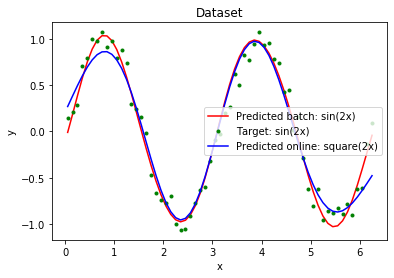

In [91]:
plt.plot(x_test, output_sin_batch,'r', label="Predicted batch: sin(2x)")
plt.plot(x_test, y_sin_test_noisy ,'g.', label="Target: sin(2x)")
plt.plot(x_test, output_sin_online, 'b', label="Predicted online: square(2x)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Dataset")
plt.legend()

### Competitive learning (CL) to initialise RBF units

Placing the RBFs in the input space. We will use a version of CL for Vector Quantization. A simple algorithm we use here can only adjust the positions of the RBF units without adjusting the width of the units. 
Therefore you will have to make these adjustment yourselves based on the distribution of data around the cluster centers found with this simple CL algorithm. 

CL algorithm: At each iteration of CL a training vector is randomly selected from the data. The closest RBF unit (usually called the winning unit) is computed, and this unit is updated, in such a way that it gets closer to the training vector. The other units may or may not (depending on the version of CL used) be moved towards it too, depending on distance. This way the units will tend to aggregate in the clusters in the data space.

#### Compare CL based with manually positioned

Compare the CL-based approach with your earlier RBF network where you manually positioned RBF nodes in the input space. Make this comparison for both noise-free and noisy approximation of sin(2x) and use the number of units corresponding to the best performing architectures found in sections 3.1 and 3.2, respectively. Pay attention to convergence, generalisation performance and the resulting position of nodes.

---


In [107]:
num_nodes = 6
mus = cl_competitive(num_nodes,x_train, iterations=100, lr=0.01)
# at all turnpoints/max/minima
rbf_sin_cl = RBF(num_nodes=num_nodes, sigma=1, mus=mus)
rbf_sin_cl.fit_delta(x_train, y_sin_train_noisy, num_epochs=100, learning_rate=0.01)
output_sin_cl = rbf_sin_cl.predict(x_test)
print('The error for Sin function in batch learning with noisy data and cl units is: ', np.mean(abs(y_sin_test_noisy - output_sin_cl)))


The error for Sin function in batch learning with noisy data and cl units is:  0.6282703213780126


#### Smooth Boundary
Introduce a strategy to avoid dead units, e.g. by having more than a single winner. Choose an example to demonstrate this effect in comparison with the vanilla version of our simple CL algorithm.

---

-> With 2 units changes the results are better



In [108]:
num_nodes = 6
mus = cl_competitive(num_nodes=num_nodes,input_space=x_train, num_winners=2, iterations=100, lr=0.01)
# at all turnpoints/max/minima
rbf_sin_cl = RBF(num_nodes=num_nodes, sigma=1, mus=mus)
rbf_sin_cl.fit_delta(x_train, y_sin_train_noisy, num_epochs=100, learning_rate=0.01)
output_sin_cl = rbf_sin_cl.predict(x_test)
print('The error for Sin function in batch learning with noisy data and cl units with 2 winners is: ', np.mean(abs(y_sin_test_noisy - output_sin_cl)))


The error for Sin function in batch learning with noisy data and cl units with 2 winners is:  0.6797386028060118


#### Two dimensional

Configure an RBF network with the use of CL for positioning the RBF units to approximate a two-dimensional function, i.e. from R2 to R2. 

As training examples use noisy data from ballistical experiments 
* where inputs are pairs: <angle, velocity> 
* the outputs are pairs: <dis- tance, height>.

There are two datasets available: ballist for training and balltest for testing. First thing to do is to load the data and then train the RBF network to and a mapping between the input and output values. Please be careful with the selection of a suitable number of nodes and their initialisation to avoid dead-unit and overitting problems. Report your results and observations, ideally with the support of illustrations, and document your analyses (e.g., inspect the position of units in the input space).

----

-> position in input space is equally distributed
-> but random almost equally good

In [109]:
## Read dat file
df_training = pd.read_csv(data_set_path+ 'ballist.dat', 
                 sep="\s+", #separator whitespace
                 header=None) 
df_training.columns = [['x1', 'x2', 'y1', 'y2']]

df_test = pd.read_csv(data_set_path+ 'balltest.dat', 
                 sep="\s+", #separator whitespace
                 header=None) 
df_test.columns = [['x1', 'x2', 'y1', 'y2']]

#Create arrays from pandas
training_x = df_training[['x1', 'x2']].values
training_y = df_training[['y1', 'y2']].values
test_x = df_test[['x1', 'x2']].values
test_y = df_test[['y1', 'y2']].values

#### with cl competitive

In [115]:
num_nodes = 10
mus = cl_competitive(num_nodes,training_x, iterations=10, lr=0.001)
print(mus)

[[0.14679834 0.3703366 ]
 [0.12462789 0.36367535]
 [0.71344704 0.96586578]
 [0.0415502  0.49334395]
 [0.01402351 0.72863397]
 [0.27232024 0.10211741]
 [0.91591347 0.0340287 ]
 [0.60613898 0.68149427]
 [0.45353752 0.26207586]
 [0.80166109 0.7799158 ]]


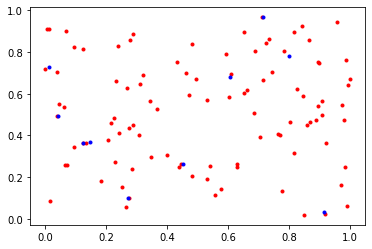

In [116]:
plt.plot(training_x[:,0], training_x[:,1], 'r.')
plt.plot(mus[:,0], mus[:,1], 'b.')

In [117]:
output_ballist = RBF(num_nodes=num_nodes, sigma=1, mus=mus)
output_ballist.fit_delta(training_x, training_y[:,0], num_epochs=30, learning_rate=0.01)
output_ballist_distance = output_ballist.predict(test_x)
print('The error for Ballist distance and cl units is: ', np.mean(abs(test_y[:,0] - output_ballist_distance)))

output_ballist.fit_delta(training_x, training_y[:,1], num_epochs=30, learning_rate=0.01)
output_ballist_height = output_ballist.predict(test_x)
print('The error for Ballist height and cl units is: ', np.mean(abs(test_y[:,1] - output_ballist_height)))


The error for Ballist distance and cl units is:  0.19636014339090335
The error for Ballist height and cl units is:  0.1535805017088218


#### without cl competitive

In [118]:
output_ballist = RBF(num_nodes=num_nodes, sigma=1)
output_ballist.fit_delta(training_x, training_y[:,0], num_epochs=30, learning_rate=0.01)
output_ballist_distance = output_ballist.predict(test_x)
print('The error for Sin function in batch learning with noisy data and cl units is: ', np.mean(abs(test_y[:,0] - output_ballist_distance)))

output_ballist.fit_delta(training_x, training_y[:,1], num_epochs=30, learning_rate=0.01)
output_ballist_height = output_ballist.predict(test_x)
print('The error for Sin function in batch learning with noisy data and cl units is: ', np.mean(abs(test_y[:,1] - output_ballist_height)))


The error for Sin function in batch learning with noisy data and cl units is:  0.21564646345589686
The error for Sin function in batch learning with noisy data and cl units is:  0.16561711311562569


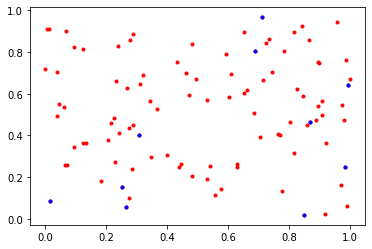

In [119]:
plt.plot(training_x[:,0], training_x[:,1], 'r.')
plt.plot(output_ballist.mus[:,0], output_ballist.mus[:,1], 'b.')

## Part II

### Topological Ordering of Animal Species

The SOM algorithm can be used to assign a natural order to objects characterized only by a large number of attributes. This is done by letting the SOM algorithm create a topological mapping from the high-dimensional attribute space to a one-dimensional output space.

#### Create Data set

Data:
* 32 animal species where each animal is characterized by 84 binary attributes. Each row contains the attributes of one animal.
* animalnames.dat: with the names of the animals in the same order. This vector should only be used to print out the final ordering in a more readable format. 

These 84 values serve as input and 100 nodes arranged in a one-dimensional topology, i.e. in a linear sequence, constitute the output.

In [120]:
animals = pd.read_csv(data_set_path+ 'animals.dat', 
                 sep=",", 
                 header=None).iloc[0].values.reshape((32,84))
print(animals.shape)

animal_names = pd.read_csv(data_set_path+ 'animalnames.txt', 
                 sep="\s+", #separator whitespace
                 header=None).values.T
print(animal_names.shape)

animal_attributes = pd.read_csv(data_set_path+ 'animalattributes.txt', 
                 sep="\s+", #separator whitespace
                 header=None).values.T
print(animal_attributes.shape)


df_animals = pd.DataFrame(animals, index = animal_names.tolist(),  columns=animal_attributes.tolist())
df_animals.head()

(32, 84)
(1, 32)
(1, 84)


,antlered,articulations,barks,big,bigears,biting,black,blood,brown,climbing,...,twowinged,warmblooded,waterliving,verybig,verylongears,verysmall,white,wingless,wings,yellow
'antelop',1,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
'ape',0,0,0,1,0,0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
'bat',0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
'bear',0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,0,0,0,0
'beetle',0,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


#### Train network

Train the SOM network by showing the attribute vector of one animal at a time. The SOM algorithm should now be able to create a mapping onto the **100 output nodes** such that similar animals tend to be close while different animals tend to be further away along the sequence of nodes. In order to get this one- dimensional topology, the network has to be trained using a **one-dimensional neighbourhood**.

By sorting this vector we will get the animals in the desired order. Check the resulting order. Does it make sense? If everything works, animals next to each other in the listing should always have some similarity between them. Insects should typically be grouped together, separate from the different cats, for example.

---

-> makes a little bit sense, insects are grouped together, cat/dog and lion are together


In [121]:
som = SOM(num_nodes=100)
som.fit(x=animals, neighbours_init=50)
positions = som.predict(animals) # calculate index of winning output node


self.weights:  (100, 84)


In [122]:
arranged_animals = np.concatenate((np.array(positions), animal_names.T), axis=1)
arranged_animals[arranged_animals[:, 0].argsort()]

array([[2, "'housefly'"],
       [4, "'moskito'"],
       [9, "'butterfly'"],
       [12, "'dragonfly'"],
       [14, "'grasshopper'"],
       [16, "'beetle'"],
       [20, "'pelican'"],
       [22, "'duck'"],
       [27, "'penguin'"],
       [29, "'ostrich'"],
       [33, "'frog'"],
       [36, "'seaturtle'"],
       [38, "'crocodile'"],
       [43, "'walrus'"],
       [46, "'bear'"],
       [47, "'hyena'"],
       [50, "'dog'"],
       [55, "'rat'"],
       [58, "'rabbit'"],
       [61, "'kangaroo'"],
       [63, "'elephant'"],
       [65, "'bat'"],
       [69, "'skunk'"],
       [72, "'cat'"],
       [73, "'lion'"],
       [76, "'ape'"],
       [79, "'camel'"],
       [81, "'giraffe'"],
       [83, "'pig'"],
       [88, "'horse'"],
       [92, "'antelop'"],
       [98, "'spider'"]], dtype=object)

### Cyclic Tour

Now the same technique can be used to layout a curve in a two-dimensional plane so that it passes a set of points (a variant of the travelling salesman problem). 
The training points correspond to the cities and the curve corresponds to the tour. SOM algorithm should be able to find a fairly short route which passes all cities.


Please plot both the tour and the training points. Give your interpretation.

---

#### Create Data set

The location of the ten cities is defined in the file cities.dat which defines the 10 × 2 matrix city. Each row contains the coordinates of one city (value between zero and one).

In [123]:
cities = pd.read_csv(data_set_path + "cities.txt", sep=",", header=None).values
cities

array([[0.4   , 0.4439],
       [0.2439, 0.1463],
       [0.1707, 0.2293],
       [0.2293, 0.761 ],
       [0.5171, 0.9414],
       [0.8732, 0.6536],
       [0.6878, 0.5219],
       [0.8488, 0.3609],
       [0.6683, 0.2536],
       [0.6195, 0.2634]])

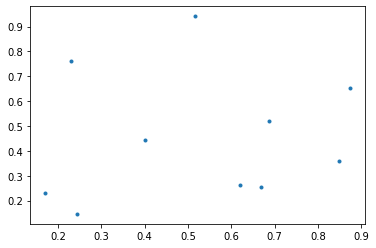

In [124]:
plt.plot(cities[:,0], cities[:,1], '.')

#### Train network

The main differences between this algorithm and the one above are:
* The input space has two dimensions instead of 84. The output grid should have 10 nodes, corresponding to the ten cities used in this example.
* The neighbourhood should be circular since we are looking for a circular tour. When calculating the neighbours you have to make sure that the first and the last output node are treated as next neighbours.
* The size of the neighbourhood must be smaller, corresponding to the smaller number of output nodes. It is reasonable to start with a neighbourhood size of 2 and then change it to 1 and finally zero.

---

In [125]:
som = SOM(num_nodes=10)
som.fit(x=cities, neighbours_init=3)
positions = som.predict(cities)


self.weights:  (10, 2)


In [126]:
tour = np.concatenate((np.array(positions), cities), axis=1)
tour = tour[tour[:, 0].argsort()]
tour

array([[0.    , 0.5171, 0.9414],
       [1.    , 0.2293, 0.761 ],
       [2.    , 0.4   , 0.4439],
       [3.    , 0.2439, 0.1463],
       [3.    , 0.1707, 0.2293],
       [5.    , 0.6683, 0.2536],
       [5.    , 0.6195, 0.2634],
       [6.    , 0.8488, 0.3609],
       [7.    , 0.6878, 0.5219],
       [8.    , 0.8732, 0.6536]])

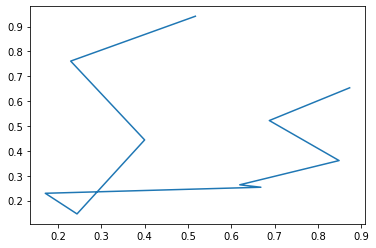

In [127]:
plt.plot(tour[:,1], tour[:,2], '-')

####  Plot the results

plot suggested tour graphically

###  Data Clustering: Votes of MPs

#### Data set creation

* votes.dat: data about how all 349 members of the Swedish parliament did vote in the 31 first votes during 2004-2005 
* mpparty.dat, mpsex.dat and mpdistrict.dat: additional information about the party, gender and district of each member of parliament (MP)
* mpnames.txt: name of the MPs

In [128]:
# How did MP vote in the 31 first votes -- (349x31) -- Coding: 1="yes-vote" , 0.5="missing-vote" , 0="no-vote"
votes = pd.read_csv(data_set_path + 'votes.dat', 
                 sep=",", 
                 header=None).iloc[0].values.reshape((349,31))
print('votes', votes.shape)

# Which party does voter belong to -- (349x1) -- Coding: 0=no party, 1='m', 2='fp', 3='s', 4='v', 5='mp', 6='kd', 7='c'      
mpparty = pd.read_csv(data_set_path + 'mpparty.txt', 
                 sep="\s+", #separator whitespace
                 header=None).values
print('mpparty', mpparty.shape)

# Gender -- (349x1) -- Coding: Male 0, Female 1
mpsex = pd.read_csv(data_set_path + 'mpsex.txt', 
                 sep="\s+", #separator whitespace
                 header=None).values
print('mpsex', mpsex.shape)

# District -- (349x1) -- Coding: distrint 1 to 29
mpdistrict = pd.read_csv(data_set_path + 'mpdistrict.dat', 
                 sep="\s+", #separator whitespace
                 header=None).values
print('mpdistrict', mpdistrict.shape)

names = []
file = open(data_set_path + 'mpnames.txt', 'r', encoding="latin-1")
for line in file: 
    names.append(line)
print('names', len(names))


votes (349, 31)
mpparty (349, 1)
mpsex (349, 1)
mpdistrict (349, 1)
names 349


#### Train SOM 

Position all MPs with the SOM algorithm on the 10 x 10 grid according to their votes.

Your task is to use the SOM algorithm to position all MPs on a 10 × 10 grid according to their votes.
By looking at where the different parties end up in the map you should be able to see if votes of the MPs actually reflect the traditional left-right scale, and if there is a second dimension as well. You should be able to see which parties are far apart and which are close.
By looking at the distribution of female and male MPs you could get some insight into whether MPs tend to vote differently depending on their gender. You can also see if there is a tendency for MPs from different districts to vote systematically different.
The file votes.dat defines a 349 × 31 matrix votes. Data are organised in row-by-row manner. Each one of 349 rows corresponds to a specific MP and each one of 31 columns to a specific vote. The elements are zero for a no-vote and one for a yes-vote. Missing votes (abstrained or non-present) are represented as 0.5.
You should use the SOM algorithm to find a topological mapping from the 31-dimensional input space to a 10 × 10 output grid. The network should be trained with each MPs votes as training data. If all works well, voting patterns that are similar will end up close to each other in the 10 × 10 map.
Please display the results with respect to different attributes (i.e. party, gender, district) and describe the results, provide your interpretation.

In [129]:
som = SOM(num_nodes=100)
som.fit(x=votes, two_d = True)
positions = som.predict(votes)
#print(np.array(positions))

self.weights:  (100, 31)


In [130]:
arranged_votes = np.concatenate((np.array(positions), mpparty, mpsex, mpdistrict), axis=1)
arranged_votes = arranged_votes[arranged_votes[:, 0].argsort()]
#print(arranged_votes)

In [131]:
print("position",arranged_votes[:, 0])
print("party",arranged_votes[:, 1])
print("gender",arranged_votes[:, 2])
print("district",arranged_votes[:, 3])

position [ 0  0  2  3  4  4  4  4  4  6  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  9
 11 11 11 11 11 13 14 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 16 16 17 18 18 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 22 22 24 24 24 24 24 25 27 29 29 29 29 29 31 31 31 31 33 33 33
 33 33 33 33 33 33 33 33 33 33 36 36 36 36 36 36 36 38 38 38 38 38 38 40
 40 42 45 46 46 47 47 47 47 47 47 47 49 49 49 49 49 49 50 51 54 54 54 54
 57 60 63 63 63 65 65 65 66 66 66 66 66 66 66 66 66 68 68 68 68 68 68 68
 69 69 71 71 74 74 74 74 74 74 74 74 76 77 77 77 77 78 79 79 79 80 82 82
 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82
 82 82 82 82 85 85 85 85 88 88 88 93 93 96

### Visualize: Gender

In [132]:
men = arranged_votes[arranged_votes[:,2] == 0]


Text(0.5, 1.0, 'Men')

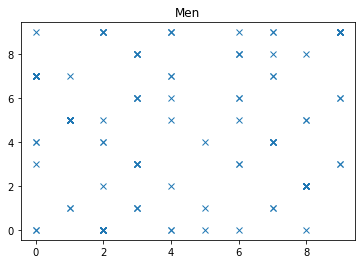

In [133]:
plt.plot(np.array(men[:,0] / 10).astype(int), (men[:,0] % 10), 'x')
plt.title("Men")

In [134]:
women = arranged_votes[arranged_votes[:,2] == 1]


Text(0.5, 1.0, 'Women')

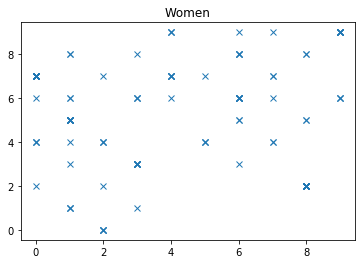

In [135]:
plt.plot(np.array(women[:,0] / 10).astype(int), (women[:,0] % 10), 'x')
plt.title("Women")

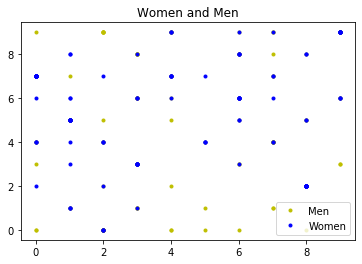

In [136]:
plt.plot(np.array(men[:,0] / 10).astype(int), (men[:,0] % 10), 'y.', label="Men")
plt.plot(np.array(women[:,0] / 10).astype(int), (women[:,0] % 10), 'b.', label="Women")
plt.title("Women and Men")
plt.legend()

### Visualize: Party

In [137]:
party0 = arranged_votes[arranged_votes[:,1] == 0]
party1 = arranged_votes[arranged_votes[:,1] == 1]
party2 = arranged_votes[arranged_votes[:,1] == 2]
party3 = arranged_votes[arranged_votes[:,1] == 3]
party4 = arranged_votes[arranged_votes[:,1] == 4]
party5 = arranged_votes[arranged_votes[:,1] == 5]
party6 = arranged_votes[arranged_votes[:,1] == 6]
party7 = arranged_votes[arranged_votes[:,1] == 7]

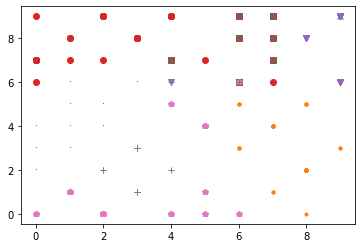

In [138]:
plt.plot(np.array(party0[:,0] / 10).astype(int), (party0[:,0] % 10), 'x')
plt.plot(np.array(party1[:,0] / 10).astype(int), (party1[:,0] % 10), '.')
plt.plot(np.array(party2[:,0] / 10).astype(int), (party2[:,0] % 10), ',')
plt.plot(np.array(party3[:,0] / 10).astype(int), (party3[:,0] % 10), 'o')
plt.plot(np.array(party4[:,0] / 10).astype(int), (party4[:,0] % 10), 'v')
plt.plot(np.array(party5[:,0] / 10).astype(int), (party5[:,0] % 10), 's')
plt.plot(np.array(party6[:,0] / 10).astype(int), (party6[:,0] % 10), 'p')
plt.plot(np.array(party7[:,0] / 10).astype(int), (party7[:,0] % 10), '+')

### Visualize: District

In [139]:
df = pd.DataFrame(data=arranged_votes, columns=['weight_vector', 'mpparty', 'mpsex', 'mpdistrict'])
df

,weight_vector,mpparty,mpsex,mpdistrict
0,0,6,0,23
1,0,6,0,16
2,2,2,1,1
3,3,2,0,16
4,4,2,1,1
...,...,...,...,...
344,99,4,0,24
345,99,4,0,28
346,99,4,1,2
347,99,0,1,2


In [141]:
df_district = df.drop(['mpparty','mpsex'], axis=1)
df_district

,weight_vector,mpdistrict
0,0,23
1,0,16
2,2,1
3,3,16
4,4,1
...,...,...
344,99,24
345,99,28
346,99,2
347,99,2


In [142]:
print(df_district.groupby(['mpdistrict','weight_vector']).size())

mpdistrict  weight_vector
1           2                1
            4                1
            7                9
            11               1
            15               3
                            ..
29          15               1
            20               1
            68               1
            80               1
            99               1
Length: 239, dtype: int64


In [143]:
#pd.set_option('display.max_rows', None)
df_district.groupby(['mpdistrict','weight_vector']).size()

mpdistrict  weight_vector
1           2                1
            4                1
            7                9
            11               1
            15               3
                            ..
29          15               1
            20               1
            68               1
            80               1
            99               1
Length: 239, dtype: int64

#### Plot Grid

*Where are the different parties located? Do they reflect the traditional left-right scale? Is there a second dimension? Which parties are far apart from each other or close? 

---